In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Load datasets
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

# Merge customers with transaction data
merged_data = transactions.merge(customers, on="CustomerID")

# Aggregate transactional data for each customer
customer_summary = merged_data.groupby("CustomerID").agg({
    "TotalValue": "sum",   # Total spending
    "Quantity": "sum"      # Total items purchased
}).reset_index()

# Add customer profile features (Region and SignupDate)
customer_profiles = customers.merge(customer_summary, on="CustomerID")
customer_profiles = pd.get_dummies(customer_profiles, columns=["Region"], drop_first=True)

# Standardize numeric columns for clustering
scaler = StandardScaler()
numeric_cols = ["TotalValue", "Quantity"]
customer_profiles[numeric_cols] = scaler.fit_transform(customer_profiles[numeric_cols])


In [3]:
# Define the range of clusters to test
cluster_range = range(2, 11)

# Store evaluation metrics
db_scores = []
silhouette_scores = []
models = []

# Test different numbers of clusters
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(customer_profiles[numeric_cols])
    
    # Calculate Davies-Bouldin Index and Silhouette Score
    db_index = davies_bouldin_score(customer_profiles[numeric_cols], cluster_labels)
    silhouette_avg = silhouette_score(customer_profiles[numeric_cols], cluster_labels)
    
    # Store metrics and models
    db_scores.append(db_index)
    silhouette_scores.append(silhouette_avg)
    models.append((n_clusters, kmeans, cluster_labels))


In [4]:
# Find the best model based on the lowest Davies-Bouldin Index
best_model = models[np.argmin(db_scores)]
best_n_clusters, best_kmeans, best_labels = best_model

# Print the best clustering results
print(f"Best Number of Clusters: {best_n_clusters}")
print(f"Best DB Index: {min(db_scores):.3f}")
print(f"Silhouette Score for Best Model: {silhouette_scores[np.argmin(db_scores)]:.3f}")


Best Number of Clusters: 2
Best DB Index: 0.627
Silhouette Score for Best Model: 0.550


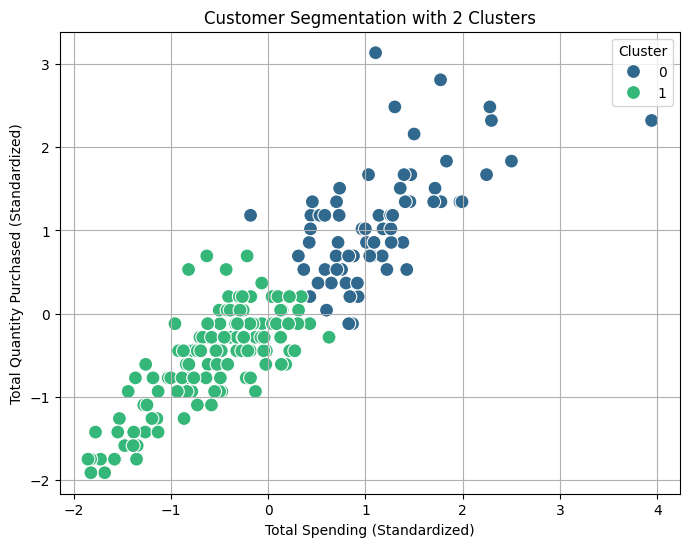

In [5]:
# Add cluster labels to the original customer profiles DataFrame
customer_profiles["Cluster"] = best_labels

# Scatter plot of clusters (Total Spending vs Quantity Purchased)
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="TotalValue", y="Quantity", 
    hue="Cluster", data=customer_profiles, palette="viridis", s=100
)
plt.title(f"Customer Segmentation with {best_n_clusters} Clusters")
plt.xlabel("Total Spending (Standardized)")
plt.ylabel("Total Quantity Purchased (Standardized)")
plt.legend(title="Cluster")
plt.grid(True)
plt.show()


In [6]:
# Save the cluster labels to a CSV file
customer_profiles[["CustomerID", "Cluster"]].to_csv("Firstname_Lastname_Clustering.csv", index=False)

# Save evaluation metrics to a CSV file
metrics_df = pd.DataFrame({
    "Number of Clusters": cluster_range,
    "Davies-Bouldin Index": db_scores,
    "Silhouette Score": silhouette_scores
})
metrics_df.to_csv("Firstname_Lastname_Clustering_Metrics.csv", index=False)

# Display the metrics DataFrame
print(metrics_df)


   Number of Clusters  Davies-Bouldin Index  Silhouette Score
0                   2              0.626704          0.550117
1                   3              0.708660          0.446298
2                   4              0.721280          0.449750
3                   5              0.776661          0.396787
4                   6              0.822510          0.393393
5                   7              0.878406          0.368170
6                   8              0.943172          0.332192
7                   9              0.880662          0.358637
8                  10              0.813754          0.365989
